# Analytics - Product Quality

#### Date: 2022/01

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2022/01
##### Professor: Hilmer Neri

##### Members:

- Arthur Paiva
- Francisco Heronildo
- José Aquiles
- Maicon Lucas Mares
- Nathalia Lorena

### LIBRARIES

In [25]:
# Deal with data
import pandas as pd
import json
from glob import glob
import glob2
import os
import re

# Deal with visualization
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [26]:
fig = plt.figure(figsize=(20, 10))

<Figure size 1440x720 with 0 Axes>

### DATAFRAME SETTINGS

In [27]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [28]:
language = [['fga-eps-mds-2022-1-Capju-User', 'js'],
           ['fga-eps-mds-2022-1-Capju-Interface', 'js'],
           ['fga-eps-mds-2022-1-Capju-Service', 'js']]

repos_language = {}

for item in language:
    repos_language[f"{item[0]}"] = item[1]

### SonarCloud

##### Path to the folder with all your jsons

In [30]:
jsons = glob('analytics-raw-data/2022-1-CAPJu/*.json') # add your path here

In [31]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2022.1-(.*?)-(.*?)-(.*?)-(.*?)-v(.*?).json", expand=True)

    df['repository'] = aux_df[2]

    df['version'] = aux_df[5]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [32]:
base_component_df = create_base_component_df(jsons)

/tmp/ipykernel_27537/1251919851.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_27537/1251919851.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_27537/1251919851.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_27537/1251919851.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_27537/1251919851.py:22: FutureWarning: The frame.append method is deprecated 

In [33]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
40,duplicated_lines_density,0.0,True,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
41,functions,82,NaN,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
42,security_rating,1.0,True,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
43,files,28,NaN,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
44,complexity,97,NaN,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
45,ncloc,1361,NaN,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
46,coverage,0.0,False,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
47,comment_lines_density,0.1,False,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
104,duplicated_lines_density,0.0,True,fga-eps-mds-2022-1-Capju-Interface-08-17-2022-...,Interface,0.2.0
105,functions,109,NaN,fga-eps-mds-2022-1-Capju-Interface-08-17-2022-...,Interface,0.2.0


#### Create dataframe per file

In [34]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [35]:
def get_files_df(df):
    
    files = df[df['qualifier'] == 'FIL'] 
    
    files = files.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])
    
    return files

In [36]:
def get_dir_df(df):
    dirs = df[df["qualifier"] == "DIR"]     
    
    print("dirs['tests']=", dirs["tests"])
    newdf = pd.to_numeric(dirs["tests"])
    print("max_value_index=", newdf)
    
    max_value_index = newdf.idxmax()            
    return dirs.loc[max_value_index]

In [37]:
def get_uts_df(df):
    dirs = df[df['qualifier'] == 'UTS']     

    dirs = dirs.dropna(subset=['test_execution_time'])          
    
    return dirs

In [38]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        
        ncloc_value = 0;
        
        for valores in component['measures']:

            if valores['metric'] == 'ncloc':
                ncloc_value = float(valores['value'])
                break
    
        if (component['qualifier'] == 'FIL') & (ncloc_value > 0) or (component['qualifier'] == 'DIR') or (component['qualifier'] == 'UTS'):                       
            file_json.append(component)

    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    df2 = pd.DataFrame(columns = df_columns)
    df3 = pd.DataFrame(columns = df_columns)
    
    
    for file in json:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        df.at[file['path'], measure['metric']] = measure['value']

                    df['qualifier'] = file['qualifier'] 

                elif file['qualifier'] == 'UTS':  
                    for measure in file['measures']:
                        df3.at[file['path'], measure['metric']] = measure['value']

                    df3['qualifier'] = file['qualifier'] 
                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        df2.at[file['path'], measure['metric']] = measure['value']
                    df2['qualifier'] = file['qualifier'] 
        except:
            pass

    df.reset_index(inplace = True)
    df2.reset_index(inplace = True)
    df3.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    df2 = df2.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    df3 = df3.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    dfFinal = pd.concat([df,df2,df3], axis=0)

    return dfFinal

def create_file_df(json_list):
    
    df = pd.DataFrame()
    dfDir = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)
                        
        file_name = os.path.basename(i)

        file_repository = re.split(r'-(\d+-\d+-\d+-\d+-\d+-\d+)-v(.*?).json', file_name)[0]

        file_language = repos_language[f"{file_repository}"]

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = file_language)
        
        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    
    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-v(.*?).json", expand=True)

    df['repository'] = aux_df[0]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['version'])
    
    return df

In [39]:
file_component_df = create_file_df(jsons)
file_component_df.repository.unique()

/tmp/ipykernel_27537/3038128456.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_27537/3038128456.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_27537/3038128456.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_27537/3038128456.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_27537/3038128456.py:80: FutureWarning: The frame.append method is deprecated 

array(['fga-eps-mds-2022-1-Capju-Interface',
       'fga-eps-mds-2022-1-Capju-Service',
       'fga-eps-mds-2022-1-Capju-User'], dtype=object)

#### Removing NaN

In [52]:
 file_component_df = file_component_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

        #### Create dataframe per repository

In [53]:
# Example. You must replace repo1, repo1,..., for your repository's names

repo1_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-Capju-Service']
repo2_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-Capju-Interface']
repo3_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-Capju-User']

In [54]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [55]:
def m1(df):

    files_df = get_files_df(df)
    
    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)
    
    return density_non_complex_files

##### COMMENTS

In [56]:
def m2(df):

    files_df = get_files_df(df)
    
    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)
    
    return density_comment_files

##### DUPLICATIONS

In [57]:
def m3(df):

    files_df = get_files_df(df)
    
    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [58]:
def m4(df):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
                   float(dir_df['tests'])

    return passed_tests

##### Fast test builds

In [59]:
def m5(df):

    dir_df = get_uts_df(df)
    
    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

##### Test coverage

In [60]:
def m6(df):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [61]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        #m4_list.append(m4(version_df))
        #m5_list.append(m5(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    """metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm5': m5_list,
                               'm6': m6_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
    """    
    
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm6': m6_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
    
    return metrics_df

In [62]:
repo1 = create_metrics_df(repo1_df)
repo2 = create_metrics_df(repo2_df)
repo3 = create_metrics_df(repo3_df)

### Data visualization

- You must do this for each of your repositories

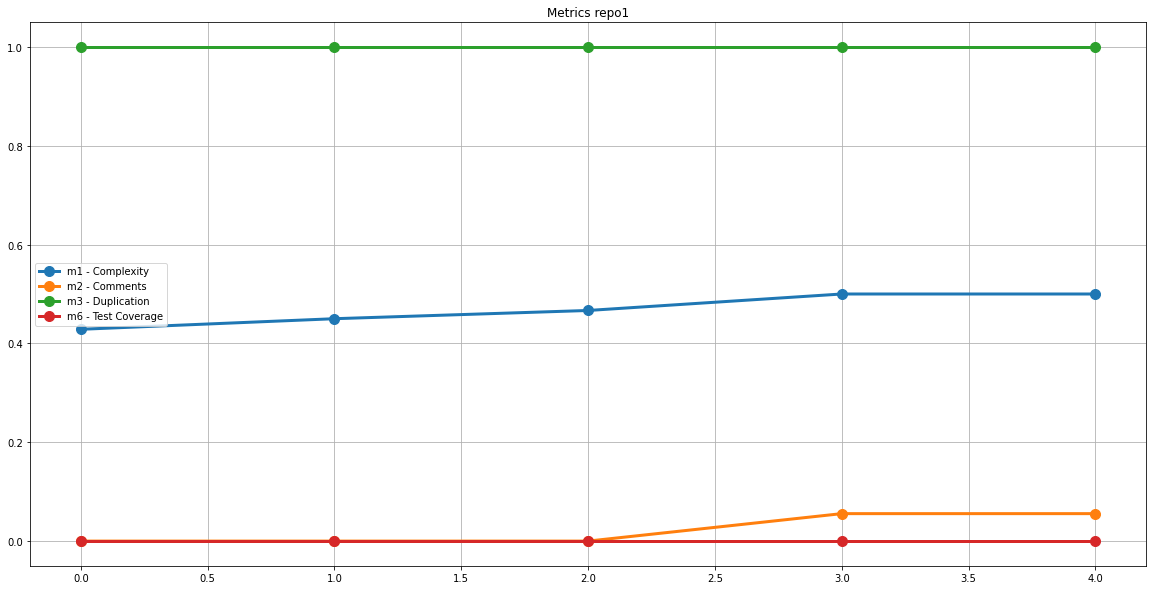

In [93]:
fig = plt.figure(figsize=(20, 10))

plt.grid(True)

plt.title('Metrics repo1')
plt.plot(repo1['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(repo1['m2'], linewidth=3, marker='o', markersize=10, label="m2 - Comments")
plt.plot(repo1['m3'], linewidth=3, marker='o', markersize=10, label="m3 - Duplication")
"""plt.plot(repo1['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m5'], linewidth=3, marker='o', markersize=10)
"""
plt.plot(repo1['m6'], linewidth=3, marker='o', markersize=10, label="m6 - Test Coverage")

plt.legend(loc='best')

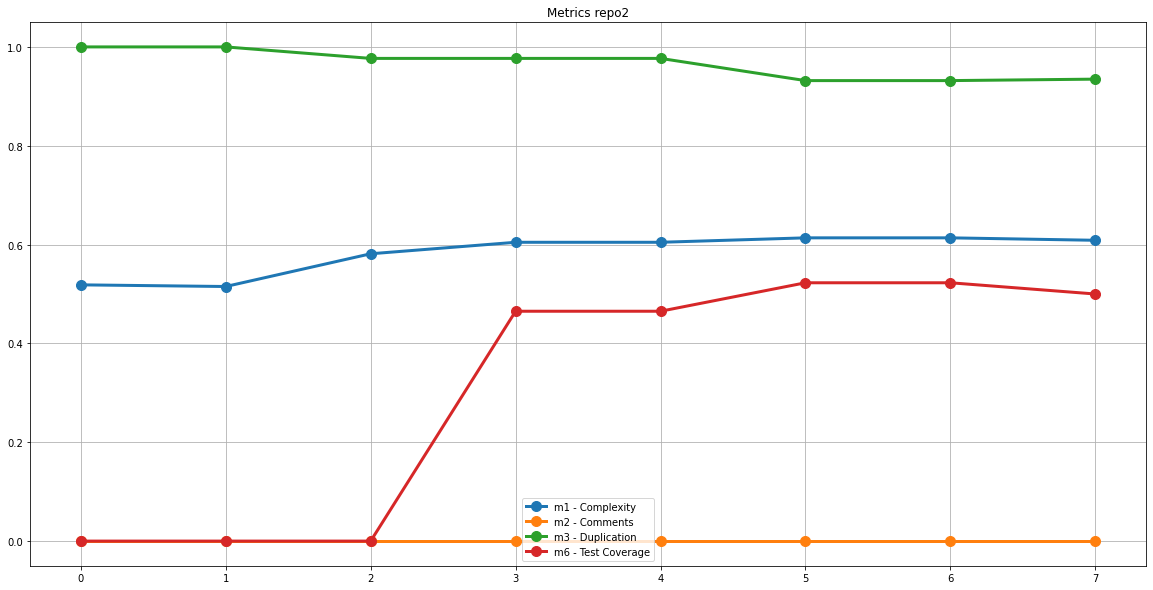

In [94]:
fig = plt.figure(figsize=(20, 10))

plt.grid(True)

plt.title('Metrics repo2')
plt.plot(repo2['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(repo2['m2'], linewidth=3, marker='o', markersize=10, label="m2 - Comments")
plt.plot(repo2['m3'], linewidth=3, marker='o', markersize=10, label="m3 - Duplication")
"""plt.plot(repo2['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m5'], linewidth=3, marker='o', markersize=10)
"""
plt.plot(repo2['m6'], linewidth=3, marker='o', markersize=10, label="m6 - Test Coverage")

plt.legend(loc='best')

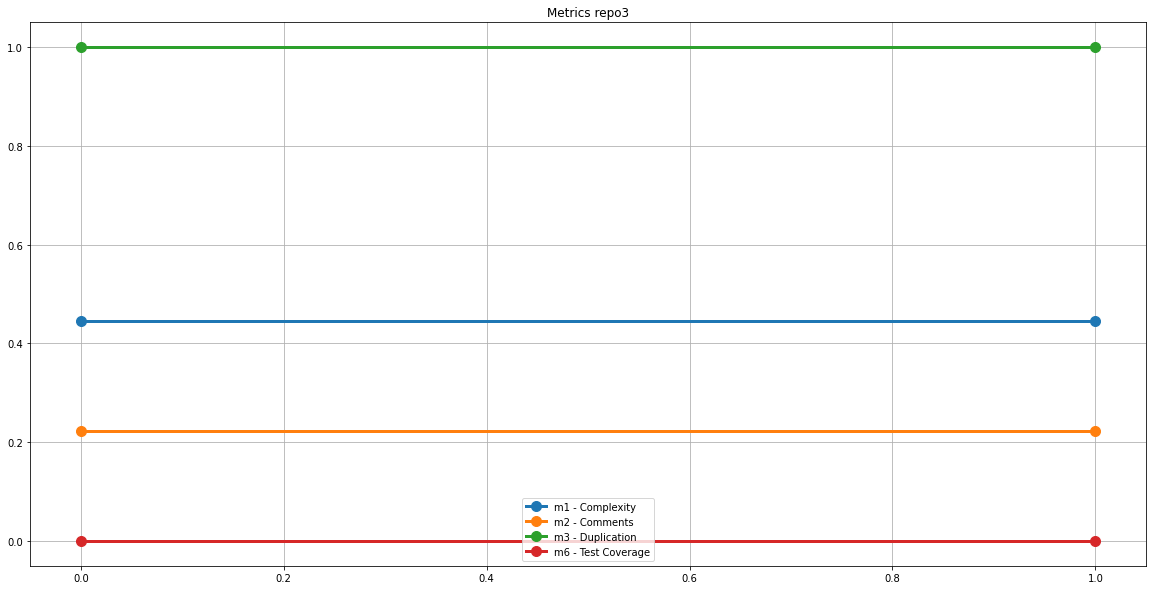

In [97]:
fig = plt.figure(figsize=(20, 10))

plt.grid(True)

plt.title('Metrics repo3')
plt.plot(repo3['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(repo3['m2'], linewidth=3, marker='o', markersize=10, label="m2 - Comments")
plt.plot(repo3['m3'], linewidth=3, marker='o', markersize=10, label="m3 - Duplication")
"""plt.plot(repo3['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m5'], linewidth=3, marker='o', markersize=10)
"""
plt.plot(repo3['m6'], linewidth=3, marker='o', markersize=10, label="m6 - Test Coverage")

plt.legend(loc='best')

### Quality factor and aspect aggregation

- You must do this for each of your repositories

In [84]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5

repo1['code_quality'] = ((repo1['m1']*pm1) + (repo1['m2']*pm2) + (repo1['m3']*pm3)) * psc1
repo2['code_quality'] = ((repo2['m1']*pm1) + (repo2['m2']*pm2) + (repo2['m3']*pm3)) * psc1
repo3['code_quality'] = ((repo3['m1']*pm1) + (repo3['m2']*pm2) + (repo3['m3']*pm3)) * psc1

repo1['testing_status'] = (repo1['m6']*pm6) * psc2
repo2['testing_status'] = (repo1['m6']*pm6) * psc2
repo3['testing_status'] = (repo1['m6']*pm6) * psc2
"""repo1['testing_status'] = ((repo1['m4']*pm4) + (repo1['m5']*pm5) + (repo1['m6']*pm6)) * psc2
repo2['testing_status'] = ((repo2['m4']*pm4) + (repo2['m5']*pm5) + (repo2['m6']*pm6)) * psc2
repo3['testing_status'] = ((repo3['m4']*pm4) + (repo3['m5']*pm5) + (repo3['m6']*pm6)) * psc2
"""

"repo1['testing_status'] = ((repo1['m4']*pm4) + (repo1['m5']*pm5) + (repo1['m6']*pm6)) * psc2\nrepo2['testing_status'] = ((repo2['m4']*pm4) + (repo2['m5']*pm5) + (repo2['m6']*pm6)) * psc2\nrepo3['testing_status'] = ((repo3['m4']*pm4) + (repo3['m5']*pm5) + (repo3['m6']*pm6)) * psc2\n"

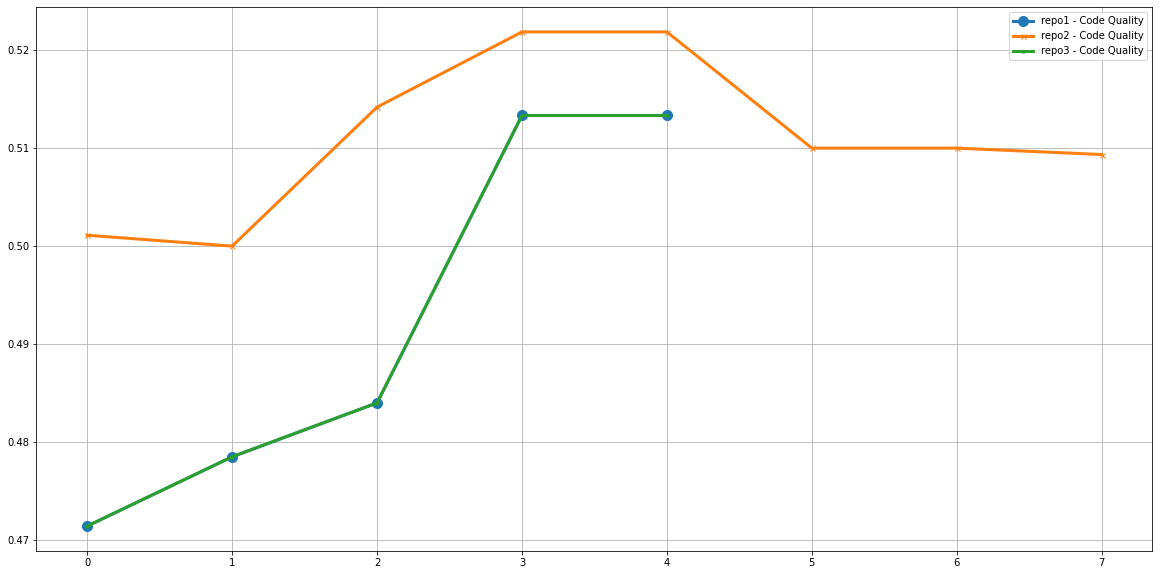

In [99]:
fig = plt.figure(figsize=(20, 10))

plt.grid(True)

plt.plot(repo1['code_quality'], linewidth=3, marker='o', markersize=10, label="repo1 - Code Quality")
plt.plot(repo2['code_quality'], linewidth=3, marker='x', markersize=5, label="repo2 - Code Quality")
plt.plot(repo1['code_quality'], linewidth=3, marker='^', markersize=3, label="repo3 - Code Quality")

plt.legend(loc='best')

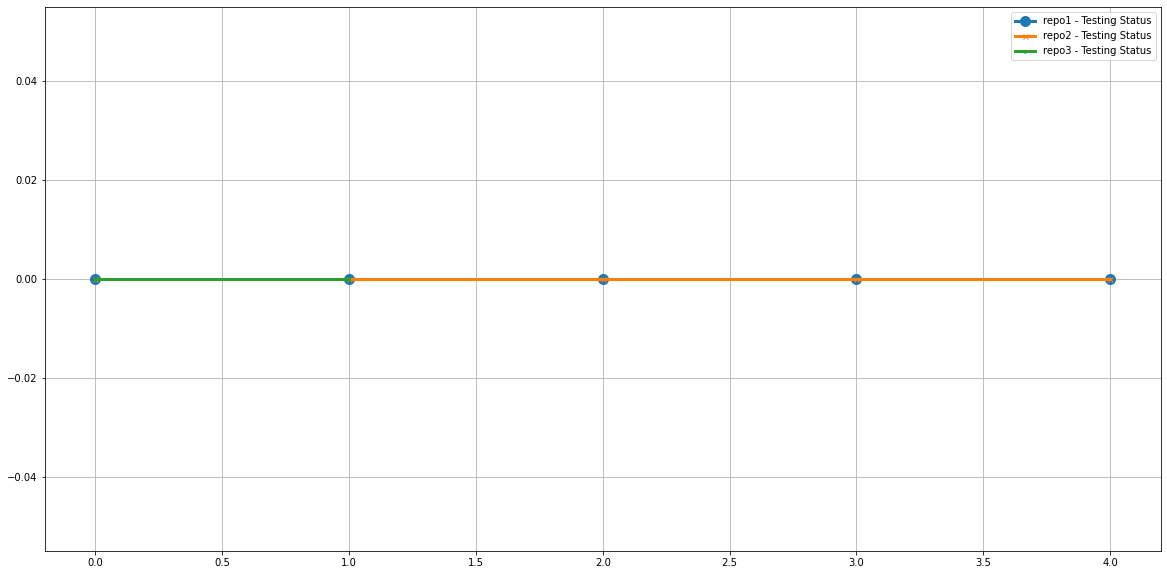

In [86]:
fig = plt.figure(figsize=(20, 10))

plt.grid(True)

plt.plot(repo1['testing_status'], linewidth=3, marker='o', markersize=10, label="repo1 - Testing Status")
plt.plot(repo2['testing_status'], linewidth=3, marker='x', markersize=5, label="repo2 - Testing Status")
plt.plot(repo3['testing_status'], linewidth=3, marker='^', markersize=3, label="repo3 - Testing Status")

plt.legend(loc='best')

In [68]:
repo1['Maintainability'] = repo1['code_quality'] * pc1
repo1['Reliability'] = repo1['testing_status'] * pc2
repo1['total'] = repo1['Maintainability'] + repo1['Reliability']

repo2['Maintainability'] = repo2['code_quality'] * pc1
repo2['Reliability'] = repo2['testing_status'] * pc2
repo2['total'] = repo2['Maintainability'] + repo2['Reliability']

repo3['Maintainability'] = repo3['code_quality'] * pc1
repo3['Reliability'] = repo3['testing_status'] * pc2
repo3['total'] = repo3['Maintainability'] + repo3['Reliability']


In [69]:
repo1

,m1,m2,m3,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.428571,0.000000,1.0,0.0,fga-eps-mds-2022-1-Capju-Service,0.1.0,2610,0.471429,0.0,0.235714,0.0,0.235714
1,0.450000,0.000000,1.0,0.0,fga-eps-mds-2022-1-Capju-Service,0.1.0-beta,1567,0.478500,0.0,0.239250,0.0,0.239250
2,0.466667,0.000000,1.0,0.0,fga-eps-mds-2022-1-Capju-Service,0.2.0,1540,0.484000,0.0,0.242000,0.0,0.242000
3,0.500000,0.055556,1.0,0.0,fga-eps-mds-2022-1-Capju-Service,0.3.0,2374,0.513333,0.0,0.256667,0.0,0.256667
4,0.500000,0.055556,1.0,0.0,fga-eps-mds-2022-1-Capju-Service,0.3.1,2323,0.513333,0.0,0.256667,0.0,0.256667


(0.1, 1.1)

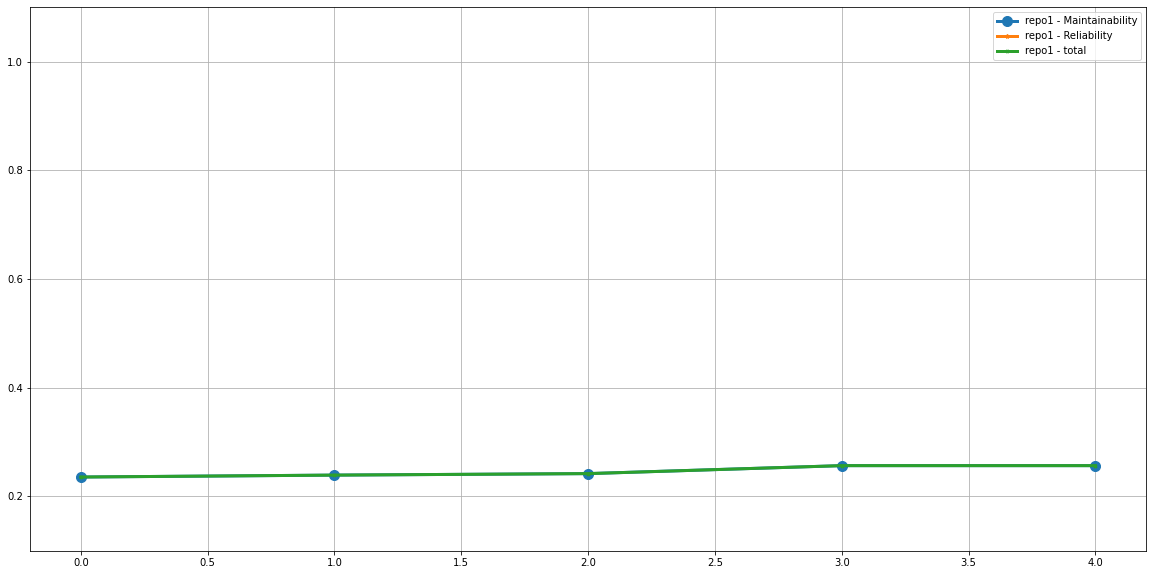

In [87]:
fig = plt.figure(figsize=(20, 10))

plt.grid(True)

plt.plot(repo1['Maintainability'], linewidth=3, marker='o', markersize=10, label='repo1 - Maintainability')
plt.plot(repo1['Reliability'], linewidth=3, marker='*', markersize=5, label='repo1 - Reliability')
plt.plot(repo1['total'], linewidth=3, marker='X', markersize=3, label='repo1 - total')

plt.legend(loc='best')
plt.ylim(0.1,1.1)

In [71]:
repo2

,m1,m2,m3,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.518519,0.0,1.000000,0.000000,fga-eps-mds-2022-1-Capju-Interface,0.1.0,5074,0.501111,0.0,0.250556,0.0,0.250556
1,0.515152,0.0,1.000000,0.000000,fga-eps-mds-2022-1-Capju-Interface,0.2.0,7368,0.500000,0.0,0.250000,0.0,0.250000
2,0.581395,0.0,0.976744,0.000000,fga-eps-mds-2022-1-Capju-Interface,0.3.0,11513,0.514186,0.0,0.257093,0.0,0.257093
3,0.604651,0.0,0.976744,0.465116,fga-eps-mds-2022-1-Capju-Interface,0.3.1,11163,0.521860,0.0,0.260930,0.0,0.260930
4,0.604651,0.0,0.976744,0.465116,fga-eps-mds-2022-1-Capju-Interface,0.3.2,11163,0.521860,0.0,0.260930,0.0,0.260930
5,0.613636,0.0,0.931818,0.522727,fga-eps-mds-2022-1-Capju-Interface,0.3.3,11914,0.510000,NaN,0.255000,NaN,NaN
6,0.613636,0.0,0.931818,0.522727,fga-eps-mds-2022-1-Capju-Interface,0.4.0,12256,0.510000,NaN,0.255000,NaN,NaN
7,0.608696,0.0,0.934783,0.500000,fga-eps-mds-2022-1-Capju-Interface,0.4.1,12880,0.509348,NaN,0.254674,NaN,NaN


(0.1, 1.1)

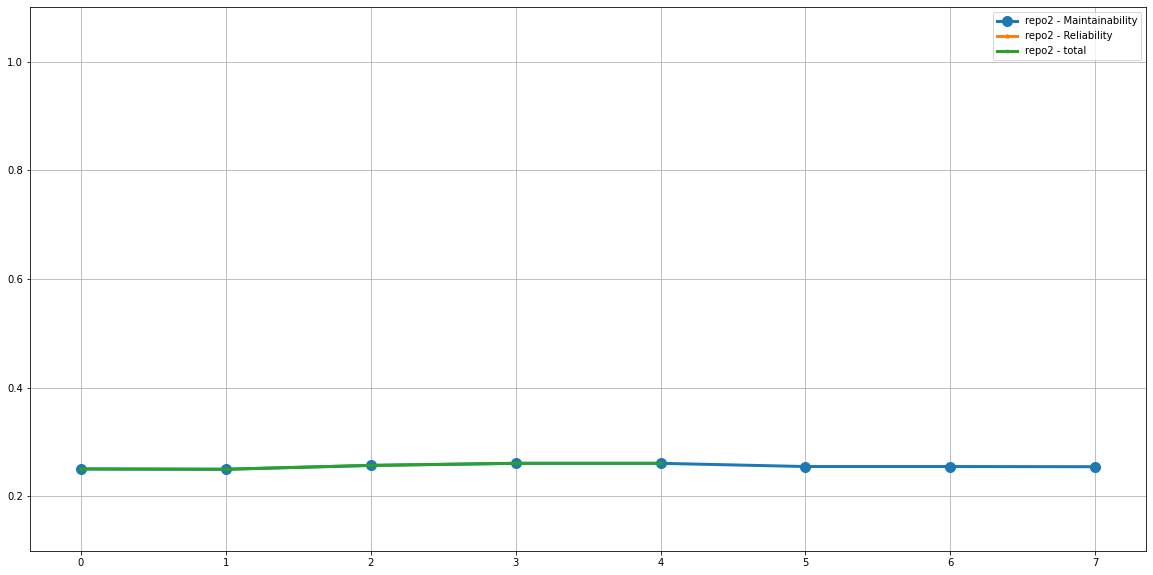

In [88]:
fig = plt.figure(figsize=(20, 10))

plt.grid(True)

plt.plot(repo2['Maintainability'], linewidth=3, marker='o', markersize=10, label='repo2 - Maintainability')
plt.plot(repo2['Reliability'], linewidth=3, marker='*', markersize=5, label='repo2 - Reliability')
plt.plot(repo2['total'], linewidth=3, marker='X', markersize=3, label='repo2 - total')

plt.legend(loc='best')
plt.ylim(0.1,1.1)

In [73]:
repo3

,m1,m2,m3,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.444444,0.222222,1.0,0.0,fga-eps-mds-2022-1-Capju-User,0.3.0,1025,0.55,0.0,0.275,0.0,0.275
1,0.444444,0.222222,1.0,0.0,fga-eps-mds-2022-1-Capju-User,0.3.1,998,0.55,0.0,0.275,0.0,0.275


(0.1, 1.1)

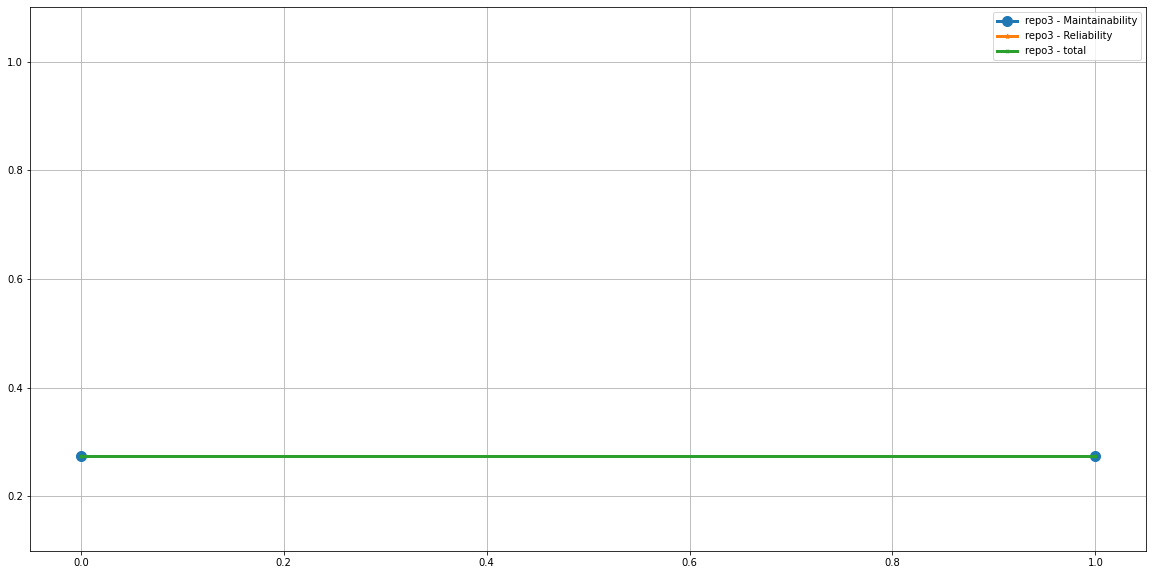

In [89]:
fig = plt.figure(figsize=(20, 10))

plt.grid(True)

plt.plot(repo3['Maintainability'], linewidth=3, marker='o', markersize=10, label='repo3 - Maintainability')
plt.plot(repo3['Reliability'], linewidth=3, marker='*', markersize=5, label='repo3 - Reliability')
plt.plot(repo3['total'], linewidth=3, marker='X', markersize=3, label='repo3 - total')

plt.legend(loc='best')
plt.ylim(0.1,1.1)

### You must do the total plot and the statics analysis for the repository with more versions.

In [75]:
# Building descriptive statistics dataframe. You must replace YourRepoName for your repository name with more product versions.

metrics_df = pd.concat([repo1, repo2, repo3], ignore_index=True)

more_versions_repo = metrics_df[metrics_df['repository'] == 'fga-eps-mds-2022-1-Capju-Interface']

def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

maintainability_stats = pd.DataFrame(get_characteristc_stats(more_versions_repo["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

reliability_stats = pd.DataFrame(get_characteristc_stats(more_versions_repo["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

In [76]:
print(maintainability_stats)

       mean     mode  median       std       var   min      max
0  0.255523  0.25500   0.255  0.004095  0.000017  0.25  0.26093
1  0.255523  0.26093   0.255  0.004095  0.000017  0.25  0.26093


In [77]:
print(reliability_stats)

   mean  mode  median  std  var  min  max
0   0.0   0.0     0.0  0.0  0.0  0.0  0.0


### Plotting the aggregated quality characteristic indicator

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6757fb5e50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6757fc5430>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6757fb5ca0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f6757fc59d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6757fc5ca0>,
 'means': []}

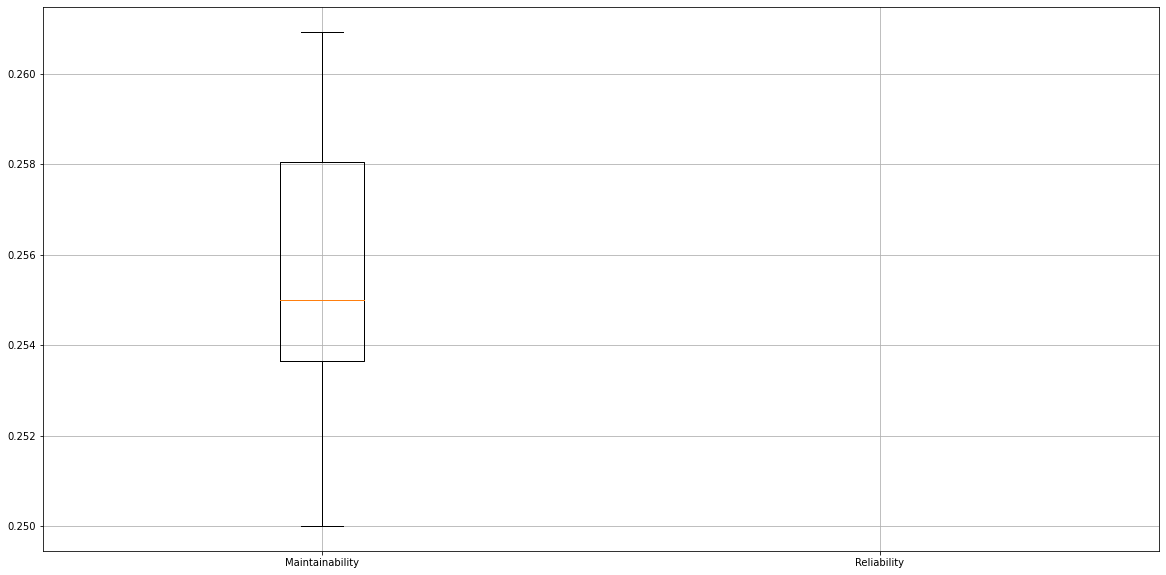

In [90]:
plt.figure(figsize=(20, 10))

plt.grid(True)

# boxplot
plt.boxplot([more_versions_repo['Maintainability'], more_versions_repo['Reliability']],
labels=['Maintainability', 'Reliability'])

### Plotting the aggregated repository quality indicator

(0.1, 1.0)

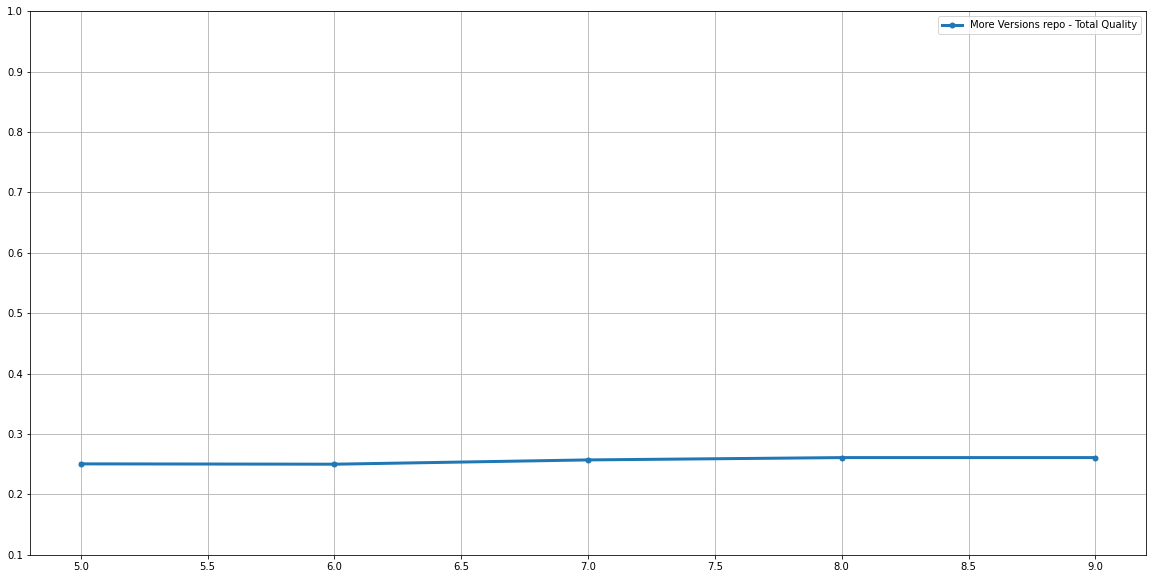

In [91]:
plt.figure(figsize=(20,10))

plt.grid(True)

plt.plot(more_versions_repo['total'], linewidth=3, marker='o', markersize=5, label='More Versions repo - Total Quality')

plt.legend(loc='best')
plt.ylim(.1,1)

In [80]:
# DATE FORMAT: MM-DD-YYYY-HH:MM:SS
currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")

metrics_df.to_excel('data/fga-eps-mds-2022-1-Capju-Interface-{}.xlsx'.format(currentDateTime), index = False)

metrics_df.to_csv('data/fga-eps-mds-2022-1-Capju-Interface-{}.csv'.format(currentDateTime), index = False)

In [ ]:
# 1) Qual é o microsserviço de backend que apresenta o pior indicador de manutenibilidade e o que 
# foi feito por seu time para melhora-lo?

# Após analisar os microsserviços de backend por meio de seus gráficos e uma média simples concluímos que o pior
# microsserviço foi o Service, entretanto, essa medida pode estar enviesada, pois só passamos a coletar dados do 
# microsserviço de User muito tempo após já termos o microsserviço de Service criado.
#
# A medida tomada pelo nosso time foi observar as métricas relacionadas a Manutenibilidade, como Complexidade,
# Duplicidade e Comentários, e a partir dessas conseguimos ter percepção da qualidade em relação a esse atributo.
# A partir dessa percepção, aceitamos ou rejeitamos Pull Requests, no caso de rejeição sugerimos mudanças de código
# visando a não degradação da qualidade quanto a esse aspecto.

In [ ]:
# 2) No microsserviço que apresentar o pior indicador de confiabilidade, mostre qual(is) o(s) 
# módulos/arquivos mais críticos e explique como seu time tratou esse problema.

# Observando os gráficos e média simples dos repositórios de microsserviços, User e Interface, concluímos que o 
# microsserviço com o pior indicador de Confiabilidade é .........
#
# Os arquivos mais críticos são (printar nome dos arquivos e métricas que evidenciem a sua criticidade)

# Após observar as métricas relacionadas à Confiabilidade (Passed Tests, Fast Test Builds e Coverage) a medida que 
# tomamos foi a realização de treinamentos de teste com o objetivo de capacitar a equipe na implementação de
# testes mais assertivos quanto possível.

In [ ]:
# 3) Explique o comportamento da qualidade do produto, observada ao longo do tempo do 
# desenvolvimento do projeto relacionado ao seu time.

